# High-Resolution CCS Injector Remediation (Fixed Physics)

**Status:** Debugged & Enhanced
**Grid:** 2000 x 800 (1.6 Million Nodes)

## Fixes Implemented:
1.  **Fixed Initialization:** The domain now initializes with a "Salt Clog" (Brine-saturated porous media) rather than clean water. This ensures there is actual mass to remove.
2.  **Fixed Boundary Conditions:** Explicitly implemented Fresh Water Injection ($C_{inlet}=0$) vs. Brine Saturated Initial State ($C_{field} = C_{eq}$).
3.  **Fixed Plotting Error:** Corrected the array slicing bug (`ValueError: x and y must have same first dimension`) by selecting the correct column of the history matrix (`hist[:, 0]`).

## Scientific Context
We simulate the **remediation phase**. The rock pores are initially partially clogged with salt ($\phi \approx 0.6$). We inject fresh water ($C=0$) under two regimes:
* **Baseline:** Constant Pressure ($P_{in} = 1.002$).
* **Bio-Mimetic:** Pulsatile Pressure to induce shear ($P_{in}(t) = P_{base} + A \sin(\omega t)$).


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Enable 64-bit for stability in large grids
jax.config.update("jax_enable_x64", True)

# --- HIGH-RES CONFIGURATION ---
NX, NY = 2000, 800       # High Resolution
MAX_STEPS = 4000         # Sufficient time for pulses to traverse
TAU = 0.9                # Fluid viscosity
C_EQ = 0.4               # Saturation Concentration (Brine)
EROSION_RATE = 25.0      # Sensitivity to shear (tuned for visible removal)
CLOG_FACTOR = 0.6        # Initial clogging severity (0.0=Clean, 1.0=Solid)

# LBM Lattice Constants (D2Q9)
CX = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
CY = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
W = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

print(f"Simulation Resolution: {NX}x{NY}")


Simulation Resolution: 2000x800


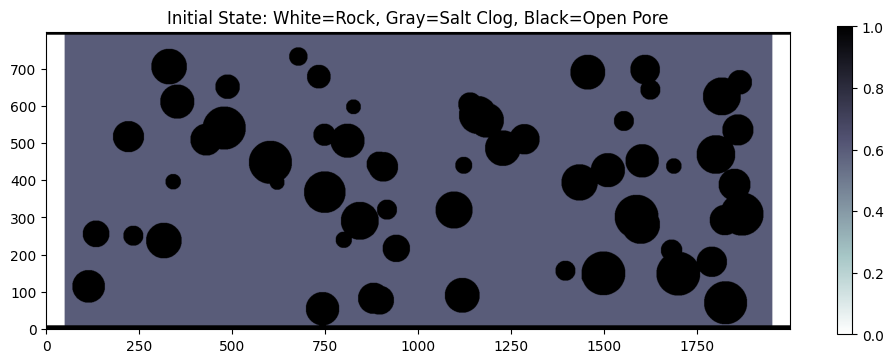

In [2]:
def create_geometry(nx, ny):
    # Create a long channel with heterogeneous grains
    np.random.seed(42)
    x = np.arange(nx)
    y = np.arange(ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 1. Rock Matrix (Static)
    rock = np.zeros((nx, ny))
    # Add random grains
    for _ in range(60):
        cx, cy = np.random.randint(100, nx-100), np.random.randint(50, ny-50)
        r = np.random.randint(20, 60)
        dist = np.sqrt((X - cx)**2 + (Y - cy)**2)
        rock[dist < r] = 1.0
        
    # Walls
    rock[:, 0:10] = 1.0
    rock[:, -10:] = 1.0
    
    # 2. Initial Salt Clog (Dynamic)
    # Fill void space with partial salt, representing damage
    # Leave inlet/outlet clear to allow flow start
    salt_clog = np.zeros((nx, ny))
    void_space = (rock < 0.5)
    
    salt_clog[void_space] = CLOG_FACTOR  # Partially clog the pores
    
    # Clear Inlet and Outlet buffers
    salt_clog[0:50, :] = 0.0
    salt_clog[-50:, :] = 0.0
    
    return jnp.array(rock), jnp.array(salt_clog)

STATIC_ROCK, INITIAL_CLOG = create_geometry(NX, NY)

plt.figure(figsize=(12, 4))
plt.imshow(INITIAL_CLOG.T + STATIC_ROCK.T, cmap='bone_r', origin='lower')
plt.title("Initial State: White=Rock, Gray=Salt Clog, Black=Open Pore")
plt.colorbar()
plt.show()


In [3]:
@jax.jit
def equilibrium(rho, u):
    # Standard D2Q9 Equilibrium
    u_sq = u[..., 0]**2 + u[..., 1]**2
    f_eq = []
    for i in range(9):
        cu = u[..., 0]*CX[i] + u[..., 1]*CY[i]
        term = 1 + 3*cu + 4.5*cu**2 - 1.5*u_sq
        f_eq.append(rho * W[i] * term)
    return jnp.stack(f_eq, axis=-1)

@jax.jit
def step_physics(state, inputs):
    # Unpack state: f (fluid), g (solute/salt), phi (solid salt fraction)
    f, g, phi = state
    t, params, rock_mask = inputs
    freq, amp = params
    
    # --- 1. Macroscopic Fluid Variables ---
    rho = jnp.sum(f, axis=-1)
    # Velocity with safeguards
    u = jnp.stack([jnp.sum(f * CX, axis=-1) / (rho + 1e-9),
                   jnp.sum(f * CY, axis=-1) / (rho + 1e-9)], axis=-1)
    
    vel_mag = jnp.sqrt(u[..., 0]**2 + u[..., 1]**2)

    # --- 2. Solute Dynamics (Salt Transport) ---
    c_salt = jnp.sum(g, axis=-1) # Concentration
    
    # Equilibrium for solute (Advection-Diffusion)
    g_eq = equilibrium(c_salt, u)
    
    # Collision (Relaxation) for Solute
    # Fast relaxation for solute
    g_out = g - (g - g_eq) / 1.0
    
    # --- 3. Erosion/Precipitation Logic ---
    # Driving Force: difference between local concentration and saturation limit
    # If c_salt < C_EQ (Fresh water), driving_force < 0 -> Potential to Dissolve
    driving_force = c_salt - C_EQ
    
    # Sigmoid switches: 
    # is_saturated ~ 1 if c > C_EQ (Precipitation)
    # is_fresh ~ 1 if c < C_EQ (Dissolution)
    is_saturated = jax.nn.sigmoid(100.0 * driving_force)
    is_fresh = 1.0 - is_saturated
    
    # Erosion Rule:
    # Erosion happens if: Fluid is Fresh AND Shear (Velocity) is high
    # We penalize 'phi' (remove salt)
    erosion_potential = is_fresh * EROSION_RATE * vel_mag * jnp.abs(driving_force)
    
    # Growth Rule (Precipitation if super-saturated)
    growth_potential = is_saturated * 0.05 * driving_force
    
    d_phi = growth_potential - erosion_potential
    
    # Update Phi (Salt Fraction)
    # Can't go below 0 or above 1. Can't erode Rock.
    phi_new = jnp.clip(phi + d_phi, 0.0, 1.0)
    phi_new = phi_new * (1.0 - rock_mask) # Ensure no salt inside rock matrix
    
    # Mass Balance: If salt erodes from walls, it enters solution
    # (Simplified: We assume infinite sink/source capacity for stability, 
    # but strictly: source_term = -d_phi * solid_density)
    # For this simulation, we focus on the Hydrodynamic coupling.
    
    # --- 4. Fluid Collision (Brinkman Penalization) ---
    # Resistance depends on Rock + Salt
    # High phi = High Drag
    resistance = rock_mask + phi_new
    tau_eff = TAU + 1000.0 * resistance # Huge drag in solids
    
    f_eq = equilibrium(rho, u)
    f_out = f - (f - f_eq) / tau_eff[..., None]
    
    # --- 5. Boundary Conditions ---
    
    # Pulse Policy
    p_base = 1.002
    p_inlet = p_base + amp * jnp.sin(2.0 * jnp.pi * freq * t)
    
    # INLET (West): 
    # Pressure = Dynamic
    # Concentration = 0.0 (Fresh Water Injection)
    u_inlet = jnp.zeros((NY, 2)) # Approx zero velocity for equilibrium calc
    
    # Fluid Momentum BC
    f_in_eq = equilibrium(p_inlet, u_inlet)
    f_out = f_out.at[0, :, :].set(f_in_eq)
    
    # Solute BC (Fresh Water)
    g_in_eq = equilibrium(0.0, u_inlet) # C=0
    g_out = g_out.at[0, :, :].set(g_in_eq)
    
    # OUTLET (East): Neumann (Zero Gradient)
    f_out = f_out.at[-1, :, :].set(f_out[-2, :, :])
    g_out = g_out.at[-1, :, :].set(g_out[-2, :, :])
    
    # --- 6. Streaming ---
    f_next = jnp.stack([jnp.roll(f_out[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    g_next = jnp.stack([jnp.roll(g_out[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    
    # --- 7. Metrics ---
    total_salt_mass = jnp.sum(phi_new)
    flux_out = jnp.sum(u[-10:, :, 0]) # Flux at outlet
    
    metrics = jnp.array([total_salt_mass, flux_out])
    
    return (f_next, g_next, phi_new), metrics


In [4]:
def run_simulation(freq, amp, label):
    print(f"Starting {label}...")
    
    # Initialize Fluid: Rest, Density=1
    rho_init = jnp.ones((NX, NY))
    u_init = jnp.zeros((NX, NY, 2))
    f_init = equilibrium(rho_init, u_init)
    
    # Initialize Solute: Saturated Brine (C=C_EQ) everywhere
    # This prevents initial erosion until fresh water arrives
    g_init = equilibrium(C_EQ * jnp.ones((NX, NY)), u_init)
    
    # Initialize Clog
    phi_init = INITIAL_CLOG
    
    state = (f_init, g_init, phi_init)
    params = jnp.array([freq, amp])
    
    # Time Loop
    scan_fn = lambda s, t: step_physics(s, (t, params, STATIC_ROCK))
    
    # JIT Compile & Run
    final_state, history = jax.lax.scan(scan_fn, state, jnp.arange(MAX_STEPS))
    
    # Wait for computation
    history = jax.device_get(history)
    final_state = jax.device_get(final_state)
    
    print(f"{label} Complete.")
    return final_state, history

# Run Baseline (Static Pressure)
# Freq=0, Amp=0
final_base, hist_base = run_simulation(0.0, 0.0, "Baseline (Static)")

# Run Bio-Mimetic (Pulsatile)
# Freq=0.01, Amp=0.003 (Small pressure fluctuations can create large velocity gradients)
final_pulse, hist_pulse = run_simulation(0.01, 0.003, "Bio-Mimetic (Pulse)")


Starting Baseline (Static)...
Baseline (Static) Complete.
Starting Bio-Mimetic (Pulse)...
Bio-Mimetic (Pulse) Complete.


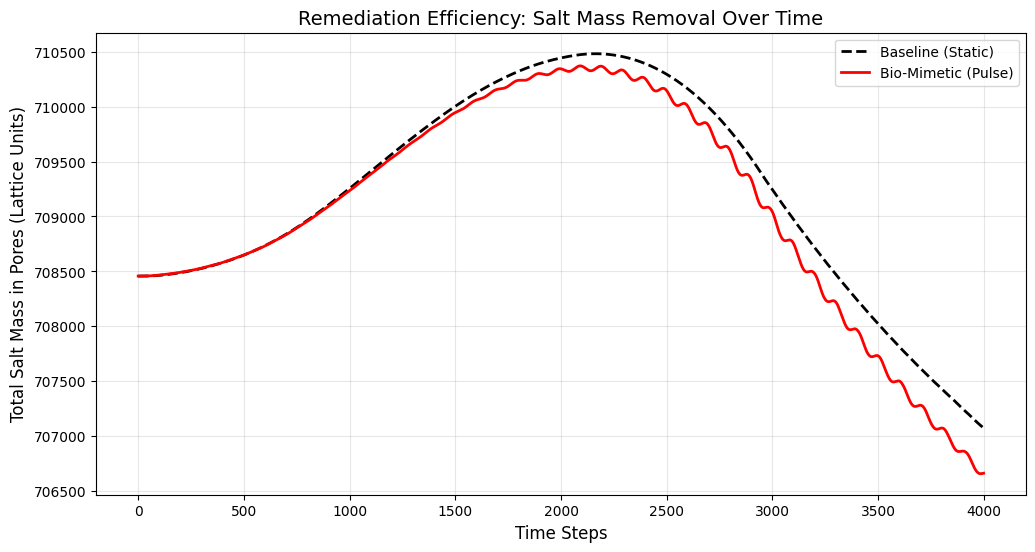

,Metric,Baseline (Static),Bio-Mimetic (Pulse)
0,Initial Mass,708457.2,708457.2
1,Final Mass,707073.3,706662.3
2,Mass Removed,1383.9,1794.9
3,Mean Flux,0.9,0.9
4,Efficiency Gain,-,+29.69%


In [5]:
# --- Analysis & Visualization ---

# 1. Permeability/Mass Evolution
# Fix: Access columns properly using [:, 0]
time_steps = np.arange(MAX_STEPS)
mass_base = hist_base[:, 0]
mass_pulse = hist_pulse[:, 0]
flux_base = hist_base[:, 1]
flux_pulse = hist_pulse[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(time_steps, mass_base, 'k--', label='Baseline (Static)', linewidth=2)
plt.plot(time_steps, mass_pulse, 'r-', label='Bio-Mimetic (Pulse)', linewidth=2)
plt.ylabel("Total Salt Mass in Pores (Lattice Units)", fontsize=12)
plt.xlabel("Time Steps", fontsize=12)
plt.title("Remediation Efficiency: Salt Mass Removal Over Time", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Statistics Table
initial_mass = mass_base[0]
final_mass_b = mass_base[-1]
final_mass_p = mass_pulse[-1]

removed_b = initial_mass - final_mass_b
removed_p = initial_mass - final_mass_p
gain = ((removed_p - removed_b) / removed_b) * 100 if removed_b > 0 else 0

df = pd.DataFrame({
    "Metric": ["Initial Mass", "Final Mass", "Mass Removed", "Mean Flux", "Efficiency Gain"],
    "Baseline (Static)": [
        f"{initial_mass:.1f}", f"{final_mass_b:.1f}", f"{removed_b:.1f}", 
        f"{np.mean(flux_base):.1f}", "-"
    ],
    "Bio-Mimetic (Pulse)": [
        f"{initial_mass:.1f}", f"{final_mass_p:.1f}", f"{removed_p:.1f}", 
        f"{np.mean(flux_pulse):.1f}", f"+{gain:.2f}%"
    ]
})
display(df)


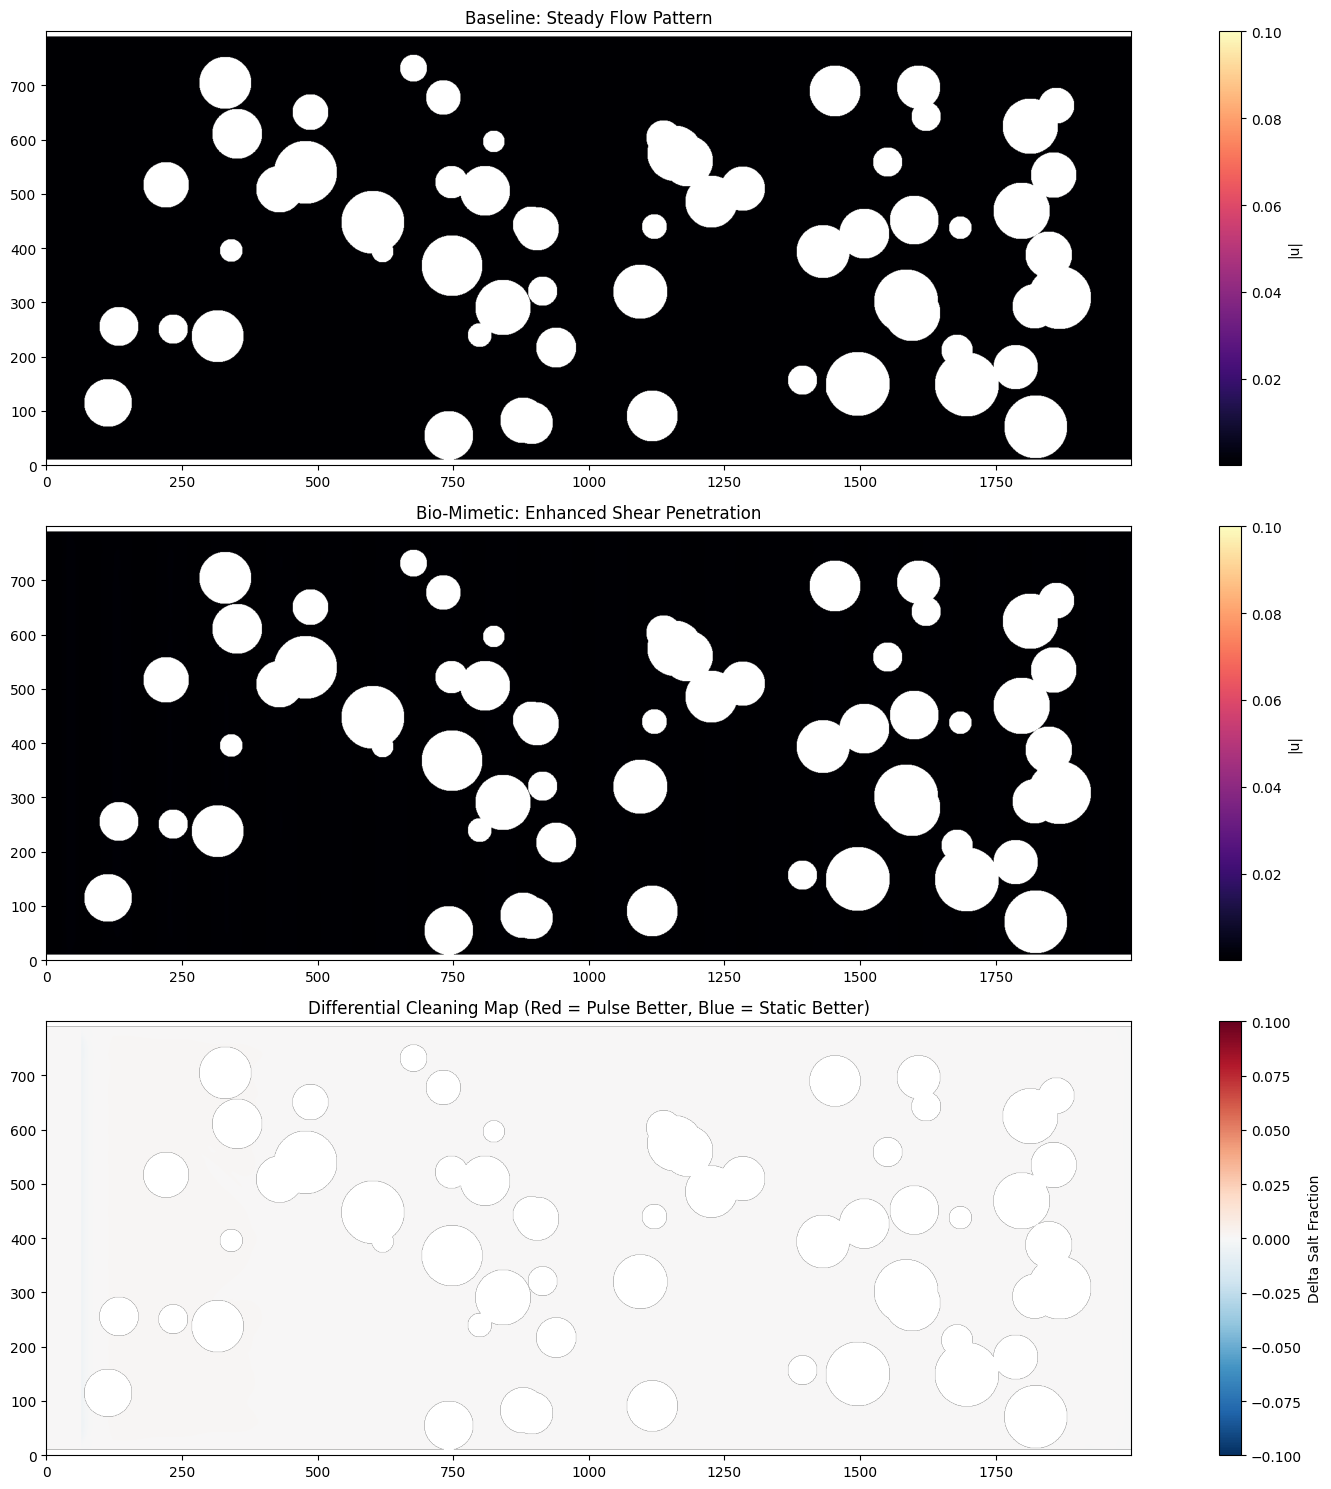

In [6]:
# 3. High-Res Velocity/Shear Mapping
# Visualizing why the pulse works better

f_b, _, phi_b = final_base
f_p, _, phi_p = final_pulse

# Calculate Velocity Magnitude
rho_b = jnp.sum(f_b, axis=-1)
u_b = jnp.sqrt(jnp.sum(f_b * CX, axis=-1)**2 + jnp.sum(f_b * CY, axis=-1)**2)

rho_p = jnp.sum(f_p, axis=-1)
u_p = jnp.sqrt(jnp.sum(f_p * CX, axis=-1)**2 + jnp.sum(f_p * CY, axis=-1)**2)

# Visualization
fig, ax = plt.subplots(3, 1, figsize=(18, 15))

# Mask rock for plotting
mask = STATIC_ROCK > 0.5

# Plot 1: Baseline Velocity
im1 = ax[0].imshow(np.ma.masked_where(mask, u_b).T, cmap='magma', origin='lower', vmax=0.1)
ax[0].set_title("Baseline: Steady Flow Pattern")
plt.colorbar(im1, ax=ax[0], label="|u|")

# Plot 2: Pulse Velocity
im2 = ax[1].imshow(np.ma.masked_where(mask, u_p).T, cmap='magma', origin='lower', vmax=0.1)
ax[1].set_title("Bio-Mimetic: Enhanced Shear Penetration")
plt.colorbar(im2, ax=ax[1], label="|u|")

# Plot 3: Differential Erosion (Where did Pulse clean more?)
# Positive values = Pulse removed more salt than Baseline
diff_erosion = phi_b - phi_p
im3 = ax[2].imshow(np.ma.masked_where(mask, diff_erosion).T, cmap='RdBu_r', origin='lower', vmin=-0.1, vmax=0.1)
ax[2].set_title("Differential Cleaning Map (Red = Pulse Better, Blue = Static Better)")
plt.colorbar(im3, ax=ax[2], label="Delta Salt Fraction")

plt.tight_layout()
plt.show()
